<a href="https://colab.research.google.com/github/eduguiu/slightdata/blob/master/Detectron2_ODetect_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries

In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=6397488cf6b6af21f203c91c7b664ca7b892d94fb02a7f311e76dbaf464850fe
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-sbo5l87y
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-sbo5l87y
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-lin

In [2]:
# install detectron2:
!pip install detectron2==0.1.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html
     |████████████████████████████████| 6.2MB 61.9MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post200513-cp36-none-any.whl size=40893 sha256=431b539ada1c568060e326d6732712d1ddcafa0fe147fcf5da33e5e5b180094a
  Stored in directory: /root/.cache/pip/wheels/a2/f6/77/551770c4b8cd75e9335cd0acf59c08d60a8684048b19da6702
Successfully built fvcore


In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow
import os
import json
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Treemap creation

- Slight
    - train
    - train_labels.csv

In [11]:
!mkdir slight_red
!mkdir slight_red/train
%cp /content/drive/My\ Drive/RCNN/slight_red/train/images/*.jpg /content/slight_red/train/
%cp /content/drive/My\ Drive/RCNN/slight_red/train_labels.csv /content/slight_red/

mkdir: cannot create directory ‘slight_red’: File exists
mkdir: cannot create directory ‘slight_red/train’: File exists


In [12]:
!mkdir slight_red/test
%cp /content/drive/My\ Drive/RCNN/slight_red/test/images/*.jpg /content/slight_red/test/
%cp /content/drive/My\ Drive/RCNN/slight_red/test_labels.csv /content/slight_red/

mkdir: cannot create directory ‘slight_red/test’: File exists


In [13]:
!ls /content/slight_red/train

0000e2d480cfb105.jpg  0de6d09228028fd3.jpg  1bbd8d66781fb6e9.jpg
00a1a64109c70d3f.jpg  0e22e5e9acefd1a8.jpg  1bed15e1294573a0.jpg
00a2f238116b247a.jpg  0e33e178bd3ae502.jpg  1c614260552490eb.jpg
00a8af5f80b52933.jpg  0e4d50629e10f191.jpg  1d3eddf902eb42af.jpg
00dd203507624d78.jpg  0f1283372ecba3b5.jpg  1dadba8327d9dc28.jpg
00eac92a6c1be596.jpg  0f30cc97d5d6b30c.jpg  1e27235941545ad3.jpg
0a495bd0e6b9e7da.jpg  0f7f1a7305b31223.jpg  1e4e41d20724a1ac.jpg
0a91a6a55d87dc84.jpg  0fd9d4bcaadfa8d9.jpg  1e75e51460aa2a11.jpg
0a9df41f5a0cf02f.jpg  0fe7bc2304cfe1ca.jpg  1ecb147dfdbdde4e.jpg
0a9fba5f2f31ff37.jpg  0ff0db20a203b6bc.jpg  1ed6c631f5c6e5c6.jpg
0acaff5d369a055f.jpg  1a67554e460a5479.jpg  1eea0b73098c45cf.jpg
0af5b13a8bae538f.jpg  1ad24e6c6603b522.jpg  1fd826bfa597ed47.jpg
0bcb87abe4e8f4b8.jpg  1ad3c256bb011f36.jpg
0dc1c834fadd319b.jpg  1b952c297c166c94.jpg


# Get Data

In [19]:
%pwd
%ls

drive/  sample_data/  slight/  slight_red/


In [0]:
dir = '/content/slight_red/'
DatasetCatalog.clear()

In [20]:
import pandas as pd

df = pd.read_csv('slight_red/train_labels.csv')
df.head()


Unnamed: 0              filename  image_id  height  ...  xmin xmax  ymin  ymax
0           1  0000e2d480cfb105.jpg         1     683  ...   582  600   473   519
1           2  0000e2d480cfb105.jpg         1     683  ...   703  710   475   524
2           3  0000e2d480cfb105.jpg         1     683  ...   760  771   487   530
3           4  00a1a64109c70d3f.jpg         2     437  ...   184  239    62   215
4           5  00a1a64109c70d3f.jpg         2     437  ...   412  452   124   194

[5 rows x 10 columns]

In [0]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
import cv2

def get_slight_dicts(csv_file, img_dir):
    df = pd.read_csv(csv_file)
    df['filename'] = df['filename'].map(lambda x: img_dir+x)

    classes = ['Street_light']

    df['class_int'] = df['class'].map(lambda x: classes.index(x))

    dataset_dicts = []
    for counter, filename in enumerate(df['filename'].unique().tolist()):
    
        record = {}
        
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["height"] = height
        record["width"] = width
        record["image_id"] = counter


        objs = []
        for index, row in df[(df['filename']==filename)].iterrows():
          obj= {
              'bbox': [row['xmin'], row['ymin'], row['xmax'], row['ymax']],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': row['class_int'],
              "iscrowd": 0
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [28]:


from detectron2.data import DatasetCatalog, MetadataCatalog

classes = ['Street light']

for d in ["train", "test"]:
  DatasetCatalog.register('slight_red/' + d, lambda d=d: get_slight_dicts('slight_red/' + d + '_labels.csv', 'slight_red/' + d+'/'))
  MetadataCatalog.get('slight_red/' + d).set(thing_classes=classes)
slight_metadata = MetadataCatalog.get('slight_red/'+d)





AssertionError: ignored

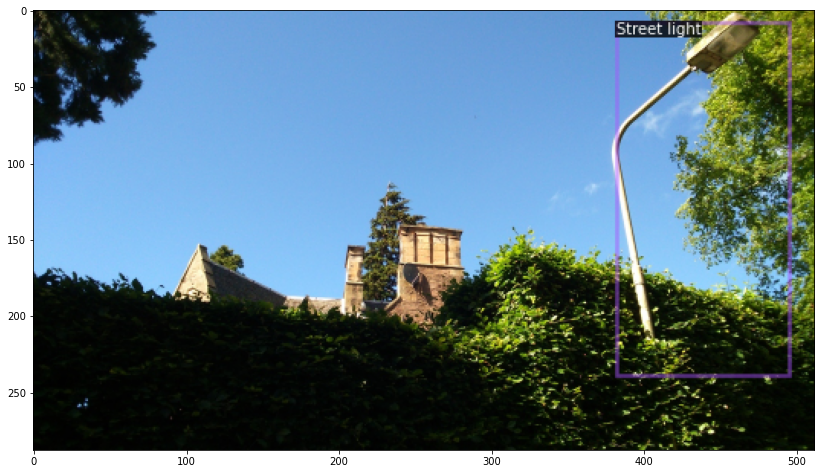

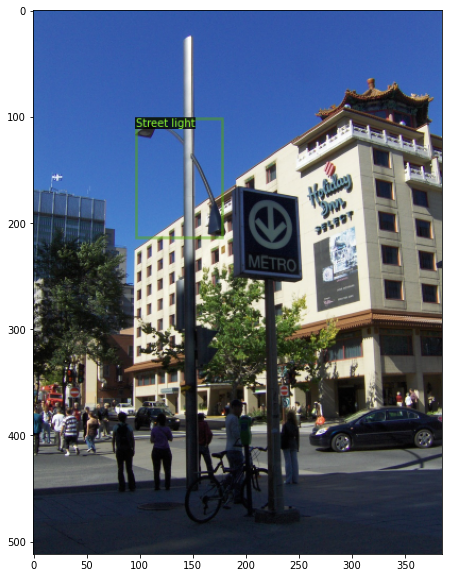

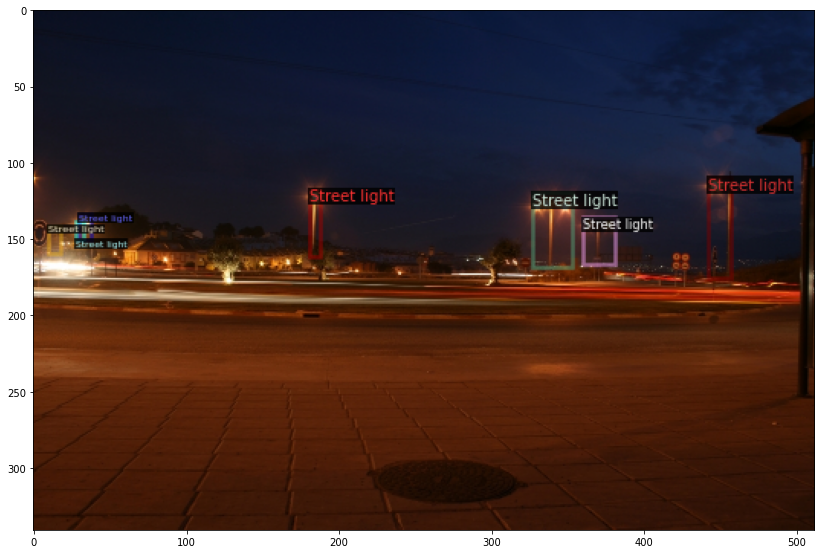

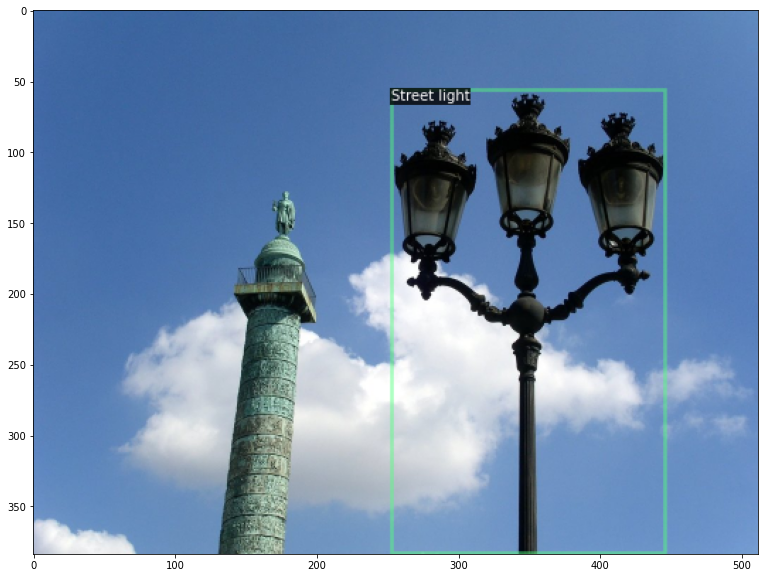

In [29]:
import random
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get('slight_red/train')
for d in random.sample(dataset_dicts, 4):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=slight_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()



# Train

In [32]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("slight_red/train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00003  # pick a good LR
cfg.SOLVER.MAX_ITER = 3000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (slight)
cfg.OUTPUT_DIR="./slight_red/output_r50"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[05/30 14:03:22 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:15, 10.6MB/s]                           
'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.


[05/30 14:03:46 d2.engine.train_loop]: Starting training from iteration 0
[05/30 14:04:34 d2.utils.events]:  eta: 1:59:46  iter: 19  total_loss: 1.420  loss_cls: 0.727  loss_box_reg: 0.088  loss_rpn_cls: 0.455  loss_rpn_loc: 0.140  time: 2.4027  data_time: 0.0755  lr: 0.000001  max_mem: 5121M
[05/30 14:05:22 d2.utils.events]:  eta: 1:59:35  iter: 39  total_loss: 1.323  loss_cls: 0.717  loss_box_reg: 0.083  loss_rpn_cls: 0.342  loss_rpn_loc: 0.141  time: 2.4084  data_time: 0.0477  lr: 0.000001  max_mem: 5121M
[05/30 14:06:12 d2.utils.events]:  eta: 2:00:47  iter: 59  total_loss: 1.437  loss_cls: 0.699  loss_box_reg: 0.081  loss_rpn_cls: 0.545  loss_rpn_loc: 0.132  time: 2.4499  data_time: 0.0524  lr: 0.000002  max_mem: 5121M
[05/30 14:07:00 d2.utils.events]:  eta: 1:58:07  iter: 79  total_loss: 1.181  loss_cls: 0.673  loss_box_reg: 0.092  loss_rpn_cls: 0.317  loss_rpn_loc: 0.095  time: 2.4298  data_time: 0.0609  lr: 0.000002  max_mem: 5121M
[05/30 14:07:49 d2.utils.events]:  eta: 1:58:3

In [0]:
#DatasetCatalog.clear()

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final_slight_red.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set the testing threshold for this model
cfg.DATASETS.TEST = ('slight_red/test', )
predictor = DefaultPredictor(cfg)

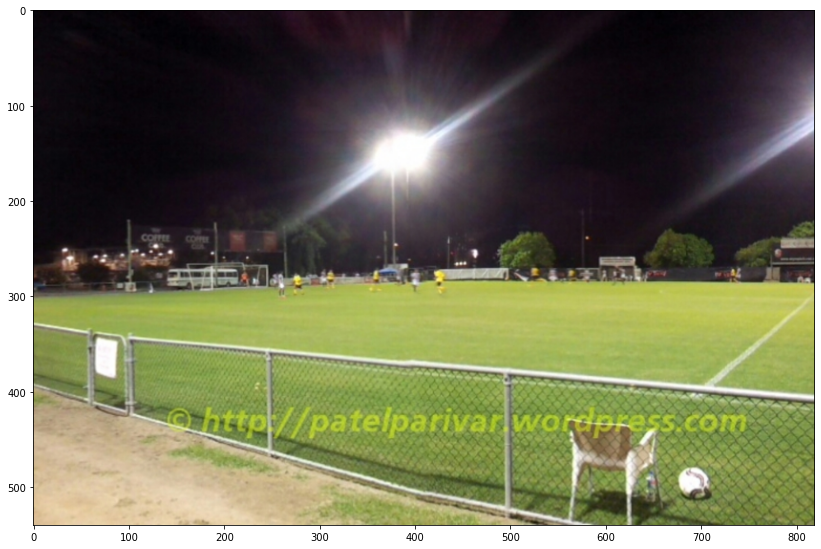

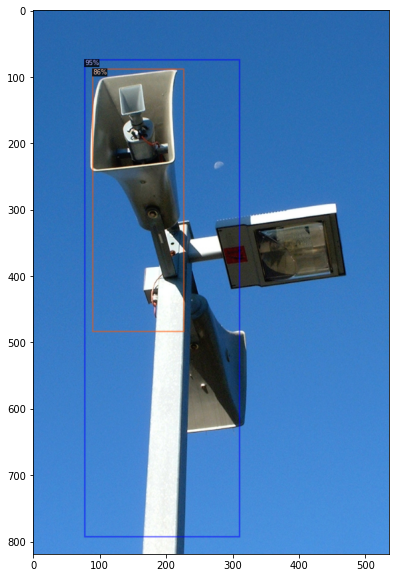

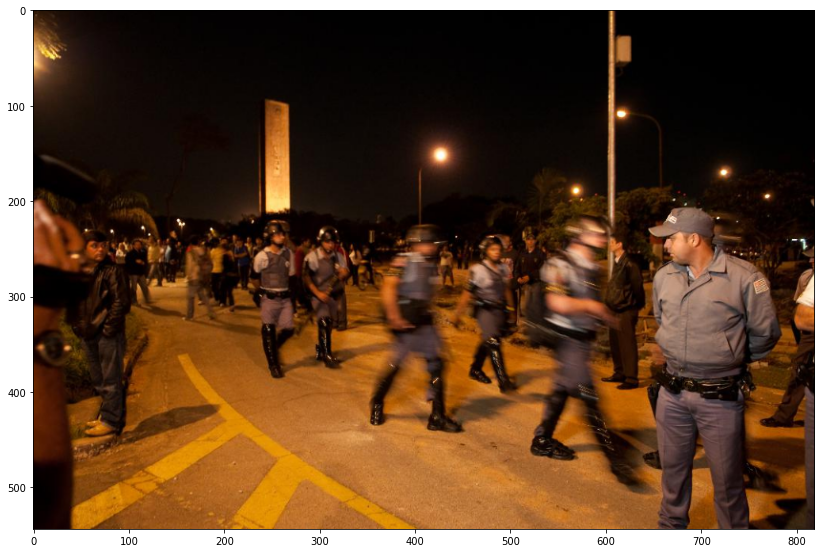

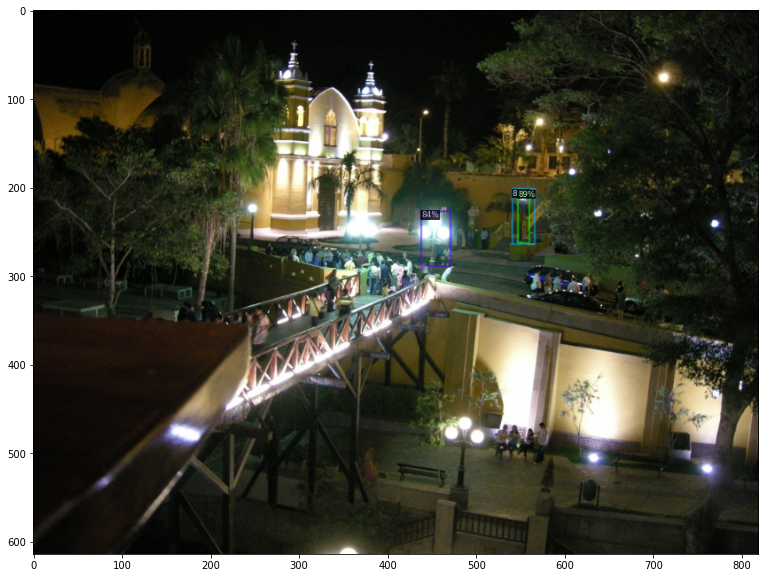

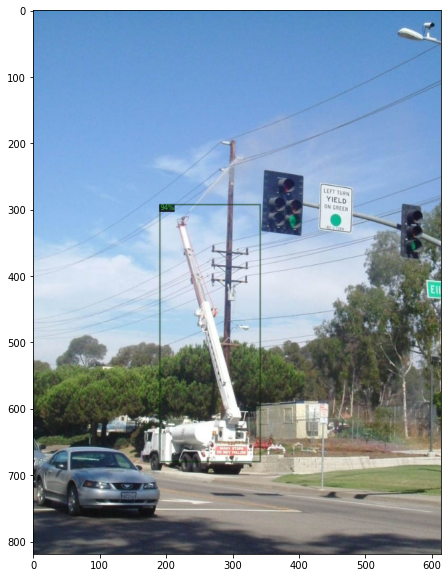

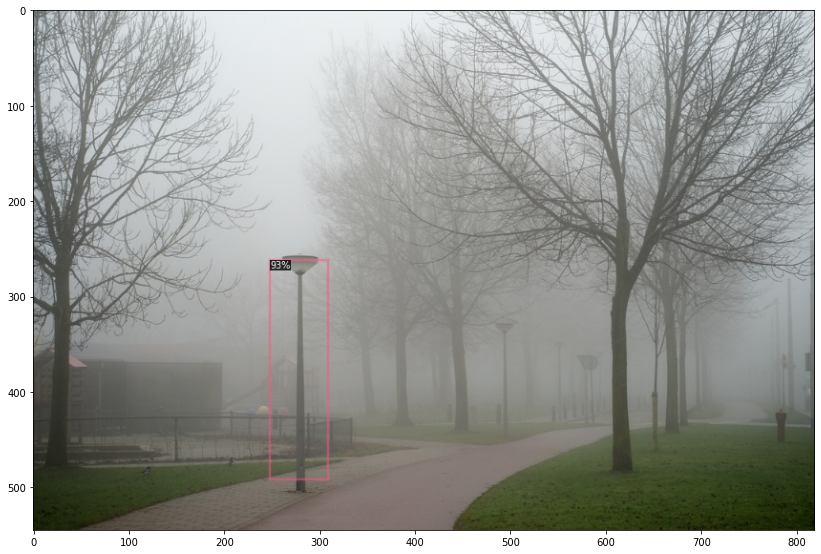

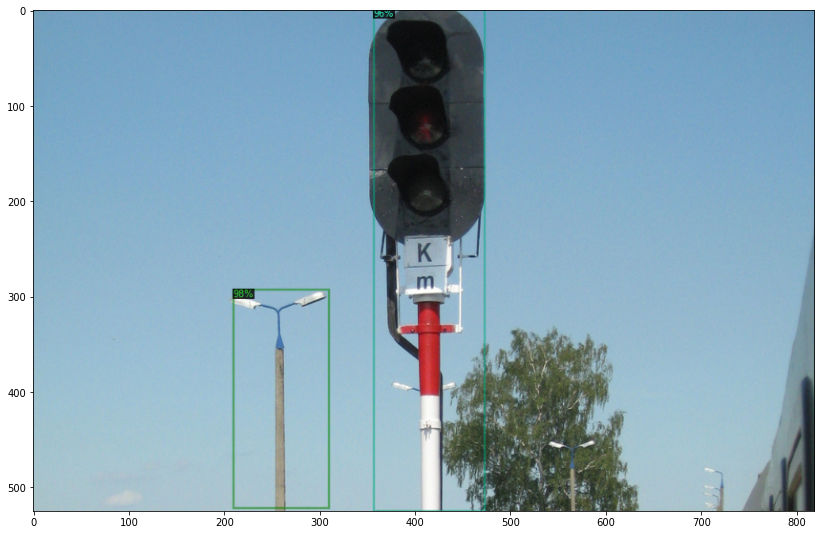

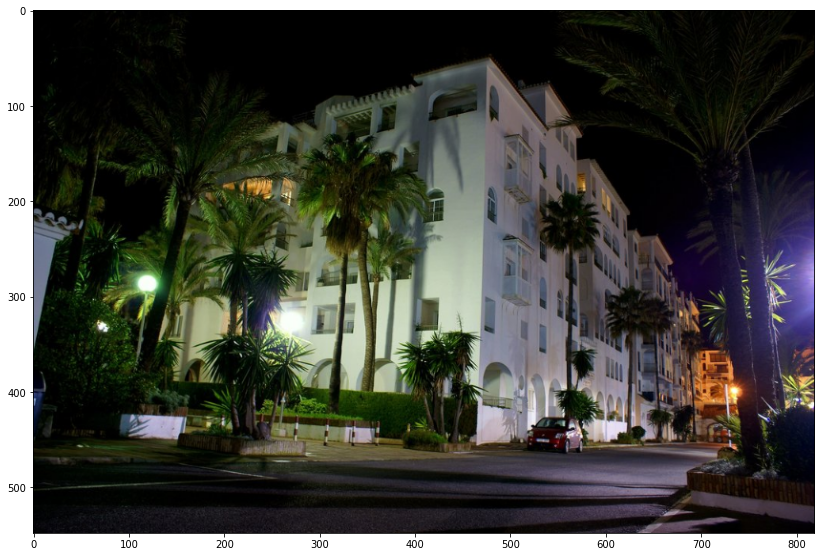

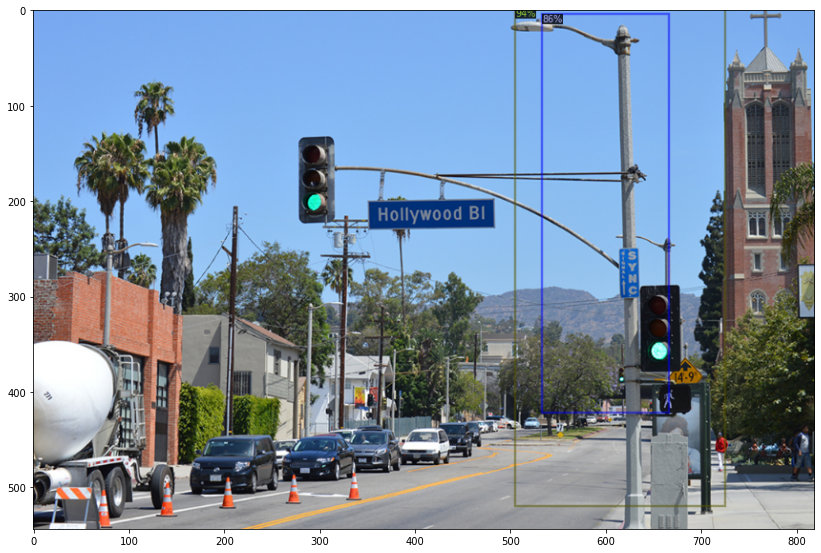

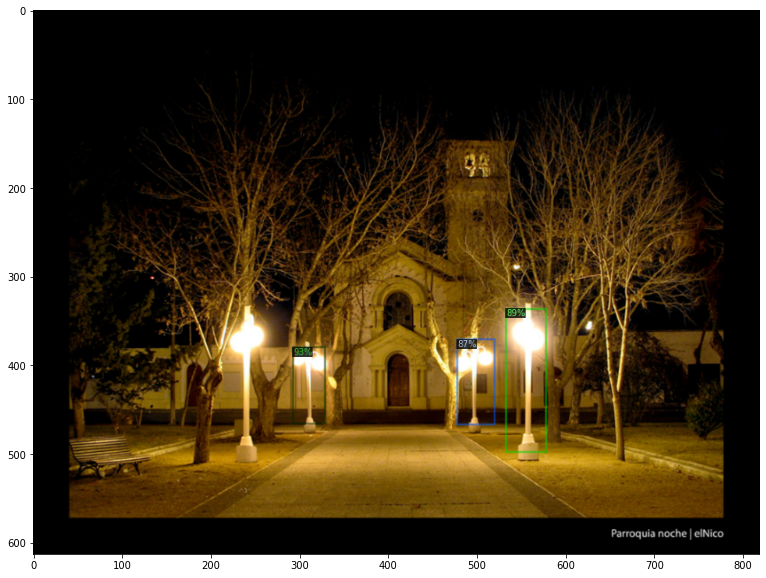

In [40]:
from detectron2.utils.visualizer import ColorMode
import random

dataset_dicts = DatasetCatalog.get('slight_red/test')
for d in random.sample(dataset_dicts, 10):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=slight_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [41]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("slight_red/test", cfg, False, output_dir="./slight_red/output_r50/")
val_loader = build_detection_test_loader(cfg, "slight_red/test")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

[05/30 16:20:37 d2.data.common]: Serializing 12 elements to byte tensors and concatenating them all ...
[05/30 16:20:37 d2.data.common]: Serialized dataset takes 0.00 MiB
[05/30 16:20:37 d2.evaluation.evaluator]: Start inference on 12 images
[05/30 16:20:41 d2.evaluation.evaluator]: Inference done 11/12. 0.3240 s / img. ETA=0:00:00
[05/30 16:20:42 d2.evaluation.evaluator]: Total inference time: 0:00:02.334653 (0.333522 s / img per device, on 1 devices)
[05/30 16:20:42 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.325761 s / img per device, on 1 devices)
[05/30 16:20:42 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/30 16:20:42 d2.evaluation.coco_evaluation]: Saving results to ./slight_red/output_r50/coco_instances_results.json
[05/30 16:20:42 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation ty

OrderedDict([('bbox',
              {'AP': 9.943089126860956,
               'AP50': 22.232120342446898,
               'AP75': 5.808820692241616,
               'APl': 22.17953608685821,
               'APm': 14.901640062913357,
               'APs': 4.247051113410126})])